In [1]:
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import random

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix


from google.colab import drive
from datetime import datetime

In [2]:
drive.mount('/content/drive')
root_path = 'drive/My Drive/KU/Robin_lab_project' 
os.chdir(root_path)

Mounted at /content/drive


In [38]:
# Set details for saving the plots
DIRECTORY = "Plots/rank_negFiltered_atleast2max_v2/"
FILENAME = "rank_negFiltered_atleast2max_v2"

# Data exploration

In [39]:
# Load data 
profiles_all = pd.read_csv("Data/ML_input/profiles_rank_negFiltered_atleast2max_v2.csv")
metadata_all = pd.read_csv("Data/ML_input/metadata_rank_negFiltered_atleast2max_v2.csv")

X = profiles_all.drop("label", axis=1)
X = StandardScaler().fit_transform(X)
y = profiles_all["label"]

print(X.shape)
print(y.shape)

(121044, 1002)
(121044,)


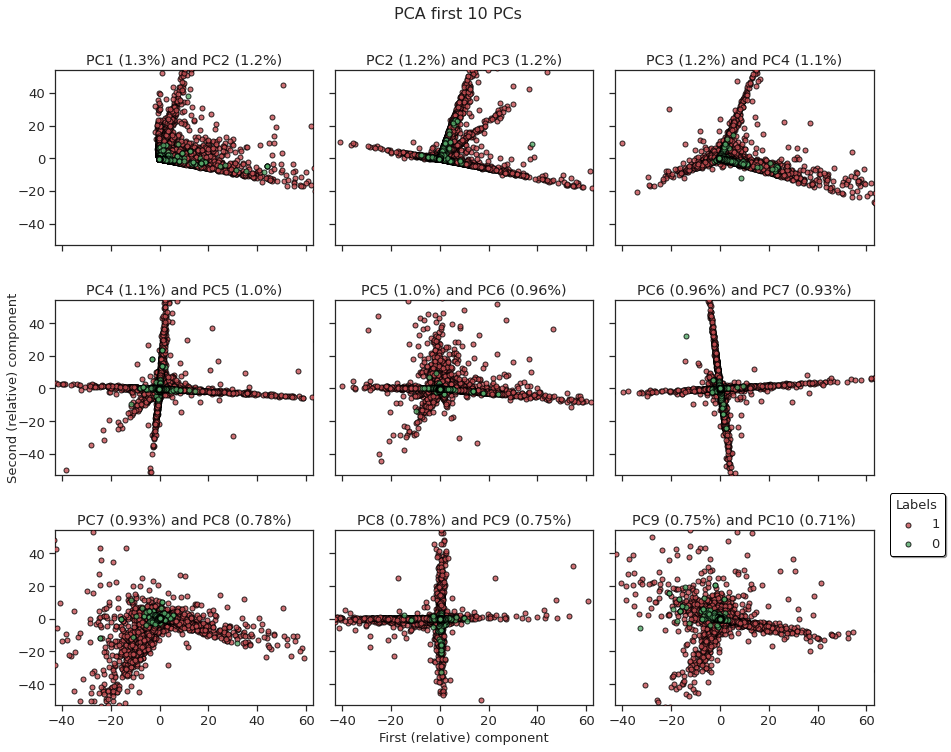

In [40]:
#  PCA plot
def multi_plot_pca(x, y, 
                   nrows=2, xlim=(-23,43), ylim=(-23,23),
                   figsize=(12,7), top=0.89,
                   title="", save=False, filename="pca_multiplot"):
  # Perform PCA and MDS
  n_pcs = nrows*3+1
  pca = PCA(n_components=n_pcs)
  pcs = pca.fit_transform(x)
  var = pca.explained_variance_ratio_ * 100
  tmp_df = pd.concat([pd.DataFrame(pcs), y], axis = 1)
  targets = [1,0]
  colors = ["r","g"]
  # Plot fig and axes
  fig, axes = plt.subplots(nrows, 3, figsize = figsize, sharex=True, sharey=True)
  fig.add_subplot(111, frameon=False)
  for target, color in zip(targets,colors):
    i_keep = tmp_df['label'] == target
    for i ,ax in enumerate(axes.flatten()):
      ax.scatter(tmp_df.loc[i_keep,i], tmp_df.loc[i_keep,i+1], zorder=3, 
                      ec="black", c=color, s=25, alpha = 0.8, label = target) 
      ax.set_title(f"PC{i+1} ({var[i]:.2}%) and PC{i+2} ({var[i+1]:.2}%)")
      ax.set_xlim(xlim)
      ax.set_ylim(ylim)
  # Details
  legend = ax.legend(title="Labels", fontsize=13, title_fontsize=13,
                     frameon = 1, shadow = True, bbox_to_anchor=(1.3, 1.25))
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
  fig.suptitle(f"PCA first {n_pcs} PCs{title}", fontsize=16)
  plt.xlabel("First (relative) component", fontsize=13)
  plt.ylabel("Second (relative) component", fontsize=13)
  fig.tight_layout()
  fig.subplots_adjust(top=top)
  if save == True:
      plt.savefig(f"{DIRECTORY}{filename}_{FILENAME}.png", dpi = 300)
  plt.show()

multi_plot_pca(X, y, nrows=3, xlim=(-43,63), ylim=(-53,54),
               figsize=(14,11), top=0.9, save=True)     

# Models development

### Split train and test by chromosomes number

In [41]:
# Load data divded by chr number
profiles_train = pd.read_csv("Data/ML_input/profiles_rank_negFiltered_atleast2max_v2_train.csv")
profiles_test = pd.read_csv("Data/ML_input/profiles_rank_negFiltered_atleast2max_v2_test.csv")
metadata_train = pd.read_csv("Data/ML_input/metadata_rank_negFiltered_atleast2max_v2_train.csv")
metadata_test = pd.read_csv("Data/ML_input/metadata_rank_negFiltered_atleast2max_v2_test.csv")

# Divide predictor and target
X_TRAIN = profiles_train.drop("label", axis = 1)
y_TRAIN = profiles_train["label"]
X_TEST = profiles_test.drop("label", axis = 1)
y_TEST = profiles_test["label"]

# # Normalization
# scaler = StandardScaler()
# X_TRAIN = scaler.fit_transform(X_TRAIN)
# X_TEST = scaler.transform(X_TEST)

print(X_TRAIN.shape)
print(y_TRAIN.shape)
print(X_TEST.shape)
print(y_TEST.shape)

(99491, 1002)
(99491,)
(21553, 1002)
(21553,)


Some useful functions

In [42]:
def get_accuracy(ypred, y):
  return sum(ypred == y) / len(y)

def get_rmse(yprob, y):
  return np.sqrt(np.mean((yprob-y)**2))

def print_eval(ytrain, ytrain_pred, ytrain_prob, ytest, ytest_pred, ytest_prob, name):
  print(f"{name} train accuracy: {get_accuracy(ytrain_pred, ytrain):.4}")
  print(f"{name} train F1-score: {f1_score(ytrain, ytrain_pred):.4}")  
  print(f"{name} train MCC: {matthews_corrcoef(ytrain, ytrain_pred):.4}")
  print(f"{name} test accuracy: {get_accuracy(ytest_pred, ytest):.4}")
  print(f"{name} test F1-score: {f1_score(ytest, ytest_pred):.4}")
  print(f"{name} test MCC: {matthews_corrcoef(ytest, ytest_pred):.4}")

def print_output_eval(train_output, val_output, name):
  train_acc = get_accuracy(train_output["ypred"].values, train_output["ytrue"].values)
  val_acc = get_accuracy(val_output["ypred"].values, val_output["ytrue"].values)
  train_f1 = f1_score(train_output["ytrue"].values, train_output["ypred"].values)
  val_f1 = f1_score(val_output["ytrue"].values, val_output["ypred"].values)
  train_mcc = matthews_corrcoef(train_output["ytrue"].values, train_output["ypred"].values)
  val_mcc = matthews_corrcoef(val_output["ytrue"].values, val_output["ypred"].values)
  print(f"\n>> {name} final report")
  print(f"Train CV accuracy: {train_acc:.4}")
  print(f"Train CV F1-score: {train_f1:.4}")
  print(f"Train MCC: {train_mcc:.4}")
  print(f"Valid CV accuracy: {val_acc:.4}")
  print(f"Valid CV F1-score: {val_f1:.4}")
  print(f"Valid CV MCC: {val_mcc:.4}")


Randomly split TRAIN into train and validation keeping labels proportion (used as faster validation in alternative to CV)

In [43]:
# Split training set into train and validation
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=20)
sss.split(X_TRAIN, y_TRAIN)

for itrain, ival in sss.split(X_TRAIN, y_TRAIN):
  X_train, X_val = X_TRAIN.iloc[itrain], X_TRAIN.iloc[ival]
  y_train, y_val = y_TRAIN[itrain], y_TRAIN[ival]

# Normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(79592, 1002)
(79592,)
(19899, 1002)
(19899,)


Subset the data for fast testing

In [44]:
# # Use reduced size for fast testing
# metadata_train = metadata_train[:3000]
# X_TRAIN, y_TRAIN = X_TRAIN[:3000], y_TRAIN[:3000]
# X_train, y_train = X_train[:2000], y_train[:2000]
# X_val, y_val = X_val[:1000], y_val[:1000] 

# print(metadata_train.shape)
# print(X_TRAIN.shape, y_TRAIN.shape)
# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)

## Random forest

In [45]:
def rf_train_pred(xtrain, ytrain, xtest, ytest, n_tree=100, name="RF"):
  start_time = datetime.now()
  # Train
  model = RandomForestClassifier(n_estimators=n_tree, bootstrap=True)
  model.fit(xtrain, ytrain)
  # Predict
  ytrain_pred = model.predict(xtrain)
  ytrain_prob = model.predict_proba(xtrain)[:,1]
  ytest_pred = model.predict(xtest)
  ytest_prob = model.predict_proba(xtest)[:,1]
  # Evaluate
  print_eval(ytrain, ytrain_pred, ytrain_prob, ytest, ytest_pred, ytest_prob, name)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return model, ytrain_prob, ytrain_pred, ytest_prob, ytest_pred,

rf_model, rf_train_yprob, rf_train_ypred, rf_val_yprob, rf_val_ypred = rf_train_pred(X_train, y_train, X_val, y_val)   

RF train accuracy: 0.9578
RF train F1-score: 0.9565
RF train MCC: 0.9181
RF test accuracy: 0.7928
RF test F1-score: 0.7753
RF test MCC: 0.5944
Duration: 0:07:29.142621


In [46]:
# Random forest CV
def rf_cv(xtrain, ytrain, metadata, n_val_chr=3, n_tree=100, name="RF"):
  start_time = datetime.now()
  print(f"Performing {name} CV")
  # Initialize arrays to store predictions and true values
  train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
  val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])
  
  # CV by chromosomes
  chr_list = np.unique(metadata.chr)
  random.shuffle(chr_list)
  k = len(chr_list) // n_val_chr
  val_chr_folds = np.array_split(chr_list, k)
  for i, val_chr in enumerate(val_chr_folds):
    print(f"\n> Starting CV iteration {i+1}, valid chrs = {val_chr}")
    ival = metadata.chr.isin(val_chr)
    X_train, X_val = X_TRAIN[~ival], X_TRAIN[ival]
    y_train, y_val = y_TRAIN[~ival], y_TRAIN[ival]

    # Normalization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    # Train and predict
    _, train_yprob, train_ypred, val_yprob, val_ypred = rf_train_pred(X_train, y_train, X_val, y_val, n_tree)
    # Store prediction on training data
    train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
    train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
    train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
    # Store prediction on validation data
    val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
    val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
    val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))

  # Stack training and validation predictions into two panda df
  train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec, "ytrue": train_ytrue_vec})
  val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec, "ytrue": val_ytrue_vec})
  # Evaluate
  print_output_eval(train_output, val_output, name)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return train_output, val_output

rf_train_output, rf_val_output = rf_cv(X_TRAIN, y_TRAIN, metadata_train)

Performing RF CV

> Starting CV iteration 1, valid chrs = ['chr19' 'chr22' 'chr11']
RF train accuracy: 0.9564
RF train F1-score: 0.9548
RF train MCC: 0.9155
RF test accuracy: 0.7097
RF test F1-score: 0.7251
RF test MCC: 0.4201
Duration: 0:08:14.759642

> Starting CV iteration 2, valid chrs = ['chr21' 'chr13' 'chr8']
RF train accuracy: 0.9583
RF train F1-score: 0.9572
RF train MCC: 0.9191
RF test accuracy: 0.7436
RF test F1-score: 0.7242
RF test MCC: 0.4875
Duration: 0:08:50.870284

> Starting CV iteration 3, valid chrs = ['chr15' 'chr10' 'chrX']
RF train accuracy: 0.9586
RF train F1-score: 0.9573
RF train MCC: 0.9198
RF test accuracy: 0.7321
RF test F1-score: 0.7234
RF test MCC: 0.4658
Duration: 0:08:29.078763

> Starting CV iteration 4, valid chrs = ['chr12' 'chrY' 'chr16']
RF train accuracy: 0.9574
RF train F1-score: 0.9561
RF train MCC: 0.9174
RF test accuracy: 0.7176
RF test F1-score: 0.7204
RF test MCC: 0.4354
Duration: 0:08:45.430955

> Starting CV iteration 5, valid chrs = ['chr

## LightGBM    

In [47]:
def lgb_train_pred(xtrain, ytrain, xtest, ytest, par, name="LGBM"):
  start_time = datetime.now()
  # Train
  train_data = lgb.Dataset(xtrain , label = ytrain)
  valid_data = lgb.Dataset(xtest, label = ytest)
  model = lgb.train(par, train_data, valid_sets=[valid_data], verbose_eval=20) 
  # Predict
  ytrain_prob = model.predict(np.array(xtrain))
  ytrain_pred = np.round(ytrain_prob)
  ytest_prob = model.predict(np.array(xtest))
  ytest_pred = np.round(ytest_prob)
  # Evaluate
  print_eval(ytrain, ytrain_pred, ytrain_prob, ytest, ytest_pred, ytest_prob, name)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return model, ytrain_prob, ytrain_pred, ytest_prob, ytest_pred

params = {"application" : "binary",
          "num_boost_round" : 400,
         # "metric" :"binary_logloss",
          "metric" :"binary_error",
          "force_row_wise" : True,
          "learning_rate" : 0.009,            
         # "sub_feature" : 0.8,
         # "sub_row" : 0.75,
         # "bagging_freq" : 1,
         # "lambda_l2" : 0.1,
         # 'verbosity': 1,
          'num_iterations' : 1500
         # 'num_leaves': 128,
         # "min_data_in_leaf": 100
}

lgb_model, lgb_train_yprob, lgb_train_ypred, lgb_val_yprob, lgb_val_ypred = lgb_train_pred(X_train, y_train, X_val, y_val, params)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's binary_error: 0.280517
[40]	valid_0's binary_error: 0.276597
[60]	valid_0's binary_error: 0.274034
[80]	valid_0's binary_error: 0.269712
[100]	valid_0's binary_error: 0.269059
[120]	valid_0's binary_error: 0.267501
[140]	valid_0's binary_error: 0.266345
[160]	valid_0's binary_error: 0.265541
[180]	valid_0's binary_error: 0.264988
[200]	valid_0's binary_error: 0.265038
[220]	valid_0's binary_error: 0.264636
[240]	valid_0's binary_error: 0.264385
[260]	valid_0's binary_error: 0.263933
[280]	valid_0's binary_error: 0.263933
[300]	valid_0's binary_error: 0.26338
[320]	valid_0's binary_error: 0.26328
[340]	valid_0's binary_error: 0.262978
[360]	valid_0's binary_error: 0.262978
[380]	valid_0's binary_error: 0.263028
[400]	valid_0's binary_error: 0.263028
[420]	valid_0's binary_error: 0.263028
[440]	valid_0's binary_error: 0.263129
[460]	valid_0's binary_error: 0.262978
[480]	valid_0's binary_error: 0.262827
[500]	valid_0's binary_error: 0.262576
[520]	valid_0's binary_error: 0

In [48]:
# LGBM CV
def lgb_cv(xtrain, ytrain, metadata, par, n_val_chr=3, kfold=10, name="LGBM"):
  start_time = datetime.now()
  print(f"Performing {name} CV")
  # Initialize 1d df to store predictions and true values
  train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
  val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])

  # CV by chromosomes
  chr_list = np.unique(metadata.chr)
  random.shuffle(chr_list)
  k = len(chr_list) // n_val_chr
  val_chr_folds = np.array_split(chr_list, k)
  for i, val_chr in enumerate(val_chr_folds):
    print(f"\n> Starting CV iteration {i+1}, valid chrs = {val_chr}")
    ival = metadata.chr.isin(val_chr)
    X_train, X_val = X_TRAIN[~ival], X_TRAIN[ival]
    y_train, y_val = y_TRAIN[~ival], y_TRAIN[ival]

    # Normalization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    # Train and predict
    _, train_yprob, train_ypred, val_yprob, val_ypred = lgb_train_pred(X_train, y_train, X_val, y_val, par=par)
    # Store prediction on training data
    train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
    train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
    train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
    # Store prediction on validation data
    val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
    val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
    val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))
  # Stack training and validation predictions into two panda df
  train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec,"ytrue": train_ytrue_vec})
  val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec,"ytrue": val_ytrue_vec})
  # Evaluate
  print_output_eval(train_output, val_output, name)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return train_output, val_output

lgb_train_output, lgb_val_output = lgb_cv(X_TRAIN, y_TRAIN, metadata_train, params)

Performing LGBM CV

> Starting CV iteration 1, valid chrs = ['chr1' 'chr16' 'chr6']


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's binary_error: 0.28129
[40]	valid_0's binary_error: 0.27705
[60]	valid_0's binary_error: 0.272466
[80]	valid_0's binary_error: 0.272167
[100]	valid_0's binary_error: 0.269682
[120]	valid_0's binary_error: 0.268354
[140]	valid_0's binary_error: 0.267412
[160]	valid_0's binary_error: 0.267069
[180]	valid_0's binary_error: 0.267026
[200]	valid_0's binary_error: 0.266255
[220]	valid_0's binary_error: 0.265827
[240]	valid_0's binary_error: 0.265656
[260]	valid_0's binary_error: 0.265913
[280]	valid_0's binary_error: 0.265399
[300]	valid_0's binary_error: 0.265185
[320]	valid_0's binary_error: 0.265356
[340]	valid_0's binary_error: 0.265185
[360]	valid_0's binary_error: 0.26497
[380]	valid_0's binary_error: 0.265142
[400]	valid_0's binary_error: 0.264628
[420]	valid_0's binary_error: 0.264842
[440]	valid_0's binary_error: 0.264885
[460]	valid_0's binary_error: 0.263985
[480]	valid_0's binary_error: 0.264199
[500]	valid_0's binary_error: 0.264371
[520]	valid_0's binary_error: 0.

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's binary_error: 0.290516
[40]	valid_0's binary_error: 0.285656
[60]	valid_0's binary_error: 0.281445
[80]	valid_0's binary_error: 0.277476
[100]	valid_0's binary_error: 0.27529
[120]	valid_0's binary_error: 0.27448
[140]	valid_0's binary_error: 0.275209
[160]	valid_0's binary_error: 0.275209
[180]	valid_0's binary_error: 0.274804
[200]	valid_0's binary_error: 0.273427
[220]	valid_0's binary_error: 0.27286
[240]	valid_0's binary_error: 0.272698
[260]	valid_0's binary_error: 0.272779
[280]	valid_0's binary_error: 0.272536
[300]	valid_0's binary_error: 0.272698
[320]	valid_0's binary_error: 0.272374
[340]	valid_0's binary_error: 0.27286
[360]	valid_0's binary_error: 0.273346
[380]	valid_0's binary_error: 0.273022
[400]	valid_0's binary_error: 0.272536
[420]	valid_0's binary_error: 0.272374
[440]	valid_0's binary_error: 0.272374
[460]	valid_0's binary_error: 0.27124
[480]	valid_0's binary_error: 0.271483
[500]	valid_0's binary_error: 0.271483
[520]	valid_0's binary_error: 0.27

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's binary_error: 0.285172
[40]	valid_0's binary_error: 0.280538
[60]	valid_0's binary_error: 0.276805
[80]	valid_0's binary_error: 0.273909
[100]	valid_0's binary_error: 0.271528
[120]	valid_0's binary_error: 0.271077
[140]	valid_0's binary_error: 0.26934
[160]	valid_0's binary_error: 0.268439
[180]	valid_0's binary_error: 0.266701
[200]	valid_0's binary_error: 0.266444
[220]	valid_0's binary_error: 0.265607
[240]	valid_0's binary_error: 0.265478
[260]	valid_0's binary_error: 0.265221
[280]	valid_0's binary_error: 0.264963
[300]	valid_0's binary_error: 0.265028
[320]	valid_0's binary_error: 0.265349
[340]	valid_0's binary_error: 0.265156
[360]	valid_0's binary_error: 0.265478
[380]	valid_0's binary_error: 0.264513
[400]	valid_0's binary_error: 0.263998
[420]	valid_0's binary_error: 0.264127
[440]	valid_0's binary_error: 0.264835
[460]	valid_0's binary_error: 0.264963
[480]	valid_0's binary_error: 0.265028
[500]	valid_0's binary_error: 0.264835
[520]	valid_0's binary_error: 

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's binary_error: 0.287064
[40]	valid_0's binary_error: 0.280228
[60]	valid_0's binary_error: 0.27681
[80]	valid_0's binary_error: 0.272587
[100]	valid_0's binary_error: 0.271247
[120]	valid_0's binary_error: 0.270643
[140]	valid_0's binary_error: 0.270241
[160]	valid_0's binary_error: 0.268767
[180]	valid_0's binary_error: 0.268432
[200]	valid_0's binary_error: 0.268767
[220]	valid_0's binary_error: 0.268029
[240]	valid_0's binary_error: 0.267627
[260]	valid_0's binary_error: 0.267761
[280]	valid_0's binary_error: 0.267694
[300]	valid_0's binary_error: 0.266622
[320]	valid_0's binary_error: 0.267091
[340]	valid_0's binary_error: 0.266823
[360]	valid_0's binary_error: 0.266823
[380]	valid_0's binary_error: 0.267158
[400]	valid_0's binary_error: 0.267158
[420]	valid_0's binary_error: 0.266957
[440]	valid_0's binary_error: 0.266957
[460]	valid_0's binary_error: 0.266354
[480]	valid_0's binary_error: 0.266354
[500]	valid_0's binary_error: 0.266354
[520]	valid_0's binary_error: 

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's binary_error: 0.28289
[40]	valid_0's binary_error: 0.27911
[60]	valid_0's binary_error: 0.277313
[80]	valid_0's binary_error: 0.276817
[100]	valid_0's binary_error: 0.276012
[120]	valid_0's binary_error: 0.275144
[140]	valid_0's binary_error: 0.273781
[160]	valid_0's binary_error: 0.273595
[180]	valid_0's binary_error: 0.273719
[200]	valid_0's binary_error: 0.273223
[220]	valid_0's binary_error: 0.272293
[240]	valid_0's binary_error: 0.271984
[260]	valid_0's binary_error: 0.271302
[280]	valid_0's binary_error: 0.271116
[300]	valid_0's binary_error: 0.270744
[320]	valid_0's binary_error: 0.271364
[340]	valid_0's binary_error: 0.270682
[360]	valid_0's binary_error: 0.27124
[380]	valid_0's binary_error: 0.271116
[400]	valid_0's binary_error: 0.27093
[420]	valid_0's binary_error: 0.27124
[440]	valid_0's binary_error: 0.270434
[460]	valid_0's binary_error: 0.270187
[480]	valid_0's binary_error: 0.27062
[500]	valid_0's binary_error: 0.270868
[520]	valid_0's binary_error: 0.270

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's binary_error: 0.280267
[40]	valid_0's binary_error: 0.27087
[60]	valid_0's binary_error: 0.265953
[80]	valid_0's binary_error: 0.266936
[100]	valid_0's binary_error: 0.265297
[120]	valid_0's binary_error: 0.263767
[140]	valid_0's binary_error: 0.26191
[160]	valid_0's binary_error: 0.262456
[180]	valid_0's binary_error: 0.263003
[200]	valid_0's binary_error: 0.261364
[220]	valid_0's binary_error: 0.261036
[240]	valid_0's binary_error: 0.261036
[260]	valid_0's binary_error: 0.260817
[280]	valid_0's binary_error: 0.260927
[300]	valid_0's binary_error: 0.259943
[320]	valid_0's binary_error: 0.260599
[340]	valid_0's binary_error: 0.260052
[360]	valid_0's binary_error: 0.260271
[380]	valid_0's binary_error: 0.26038
[400]	valid_0's binary_error: 0.260599
[420]	valid_0's binary_error: 0.261036
[440]	valid_0's binary_error: 0.261691
[460]	valid_0's binary_error: 0.26049
[480]	valid_0's binary_error: 0.26049
[500]	valid_0's binary_error: 0.259725
[520]	valid_0's binary_error: 0.25

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[20]	valid_0's binary_error: 0.271022
[40]	valid_0's binary_error: 0.268414
[60]	valid_0's binary_error: 0.266799
[80]	valid_0's binary_error: 0.265433
[100]	valid_0's binary_error: 0.264812
[120]	valid_0's binary_error: 0.263818
[140]	valid_0's binary_error: 0.263942
[160]	valid_0's binary_error: 0.263446
[180]	valid_0's binary_error: 0.2627
[200]	valid_0's binary_error: 0.261582
[220]	valid_0's binary_error: 0.262203
[240]	valid_0's binary_error: 0.261707
[260]	valid_0's binary_error: 0.261831
[280]	valid_0's binary_error: 0.26121
[300]	valid_0's binary_error: 0.260465
[320]	valid_0's binary_error: 0.260589
[340]	valid_0's binary_error: 0.26034
[360]	valid_0's binary_error: 0.260216
[380]	valid_0's binary_error: 0.260837
[400]	valid_0's binary_error: 0.260961
[420]	valid_0's binary_error: 0.26034
[440]	valid_0's binary_error: 0.26034
[460]	valid_0's binary_error: 0.260092
[480]	valid_0's binary_error: 0.259843
[500]	valid_0's binary_error: 0.259098
[520]	valid_0's binary_error: 0.259

## SVM

SVM SVC model

In [49]:
# # Train and predict SVM SVC
# def svc_train_pred(xtrain, ytrain, xtest, ytest, model, name="SVM SVC"):
#   start_time = datetime.now()
#   # Train and predict
#   model = model.fit(xtrain, ytrain)
#   ytrain_prob = model.predict_proba(xtrain)[:,1]
#   ytest_prob = model.predict_proba(xtest)[:,1]
#   ytrain_pred = model.predict(xtrain)
#   ytest_pred = model.predict(xtest)
#   # Evaluate
#   print(f"{name} train accuracy: {get_accuracy(ytrain_pred, ytrain):.4}")
#   print(f"{name} test accuracy: {get_accuracy(ytest_pred, ytest):.4}")
#   # Report time 
#   print(f"Duration: {datetime.now() - start_time}")
#   return model, ytrain_prob, ytrain_pred, ytest_prob, ytest_pred

# svc_rbf = svm.SVC(kernel='rbf', C=100, gamma=0.1, probability=True)
# #svc_model, svc_train_yprob, svc_train_ypred, svc_val_yprob, svc_val_ypred = svc_train_pred(X_train, y_train, X_val, y_val, model=svc_rbf)

SVM SVR with Logistic Regression on top of the SVM scores

In [50]:
# # Train and predict 
# def svrlr_train_pred(xtrain, ytrain, xtest, ytest, model, name="SVM SVR"):
#   start_time = datetime.now()
#   # Train and predict svm score
#   svm_model = model.fit(xtrain, ytrain)
#   svm_train_yscore = svm_model.predict(xtrain).reshape(-1,1)
#   svm_test_yscore = svm_model.predict(xtest).reshape(-1,1)
#   # Train a logistic regression on top of svm output
#   lreg_model = LogisticRegression(solver='lbfgs', 
#                                   random_state=0, 
#                                   max_iter = 2000).fit(svm_train_yscore, 
#                                                        ytrain)
#   train_yprob = lreg_model.predict_proba(svm_train_yscore)[:,1]
#   train_ypred = lreg_model.predict(svm_train_yscore)
#   test_yprob = lreg_model.predict_proba(svm_test_yscore)[:,1]
#   test_ypred = lreg_model.predict(svm_test_yscore)
#   # Evaluate
#   print(f"{name} train accuracy: {get_accuracy(train_ypred, ytrain):.4}")
#   print(f"{name} test accuracy: {get_accuracy(test_ypred, ytest):.4}")
#   # Report time 
#   print(f"Duration: {datetime.now() - start_time}")
#   return svm_model, lreg_model, train_yprob, train_ypred, test_yprob, test_ypred

# svr_rbf = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
# #_, _, svm_train_yprob, svm_train_ypred, svm_val_yprob, svm_val_ypred = svrlr_train_pred(X_train, y_train, X_val, y_val, model=svr_rbf)

SVM CV both SVC and SVR + LG

In [51]:
# # SVM CV
# def svm_cv(xtrain, ytrain, model=svc_rbf, svm_algo="SVC", kfold=10, name="SVM"):
#   start_time = datetime.now()
#   print(f"Performing {name} {svm_algo} CV")
#   # Initialize 1d df to store predictions and true values
#   train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
#   val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])
#   # Stratified CV
#   skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=26)
#   for i, (itrain, ival) in enumerate(skf.split(xtrain, ytrain)):
#     print(f"\n> Starting CV iteration {i+1}")
#     # Split data according to folds
#     X_train, X_val = xtrain.iloc[itrain], xtrain.iloc[ival]
#     y_train, y_val = ytrain[itrain], ytrain[ival]
#     # Normalization
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_val = scaler.transform(X_val)
#     # Train and predict
#     if svm_algo=="SVC":
#       _, train_yprob, train_ypred, val_yprob, val_ypred = svc_train_pred(X_train, y_train, X_val, y_val, model=model)
#     elif svm_algo=="SVR":
#       _, _, train_yprob, train_ypred, val_yprob, val_ypred = svrlr_train_pred(X_train, y_train, X_val, y_val, model=model)
#     else:
#       print("svm_algo argument must specify \"SVC\" or \"SVR\"")
#     # Store prediction on training data
#     train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
#     train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
#     train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
#     # Store prediction on validation data
#     val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
#     val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
#     val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))
#   # Stack training and validation predictions into two panda df
#   train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec,"ytrue": train_ytrue_vec})
#   val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec,"ytrue": val_ytrue_vec})
#   # Evaluate
#   train_acc = get_accuracy(train_output["ypred"].values, train_output["ytrue"].values)
#   val_acc = get_accuracy(val_output["ypred"].values, val_output["ytrue"].values)
#   train_rmse = get_rmse(train_output["yprob"].values, train_output["ytrue"].values)
#   val_rmse = get_rmse(val_output["yprob"].values, val_output["ytrue"].values)
#   print(f"\n>> {name} final report")
#   print(f"Train CV accuracy: {train_acc:.4}")
#   print(f"Valid CV accuracy: {val_acc:.4}")
#   # Report time 
#   print(f"Duration: {datetime.now() - start_time}")
#   return train_output, val_output

# # # SVC CV
# # svc_train_output, svc_val_output = svm_cv(X_TRAIN, y_TRAIN, 
# #                                           svm_algo="SVC", kfold=2, model=svc_rbf)

In [52]:
# # SVR CV
# svr_train_output, svr_val_output = svm_cv(X_TRAIN, y_TRAIN, 
#                                           svm_algo="SVR", kfold=2, model=svr_rbf)

## Features importance

,feature,rf_importance,lgb_importance_gain,lgb_importance_split
0,Plus_1,0.000837,2344.315303,131
1,Plus_2,0.000694,55.419710,5
2,Plus_3,0.000657,972.553816,9
3,Plus_4,0.000742,137.055231,12
4,Plus_5,0.000764,1927.656176,73
...,...,...,...,...
997,Minus_497,0.000852,465.135411,37
998,Minus_498,0.000779,291.116018,40
999,Minus_499,0.000751,239.166825,13
1000,Minus_500,0.000797,555.706900,26


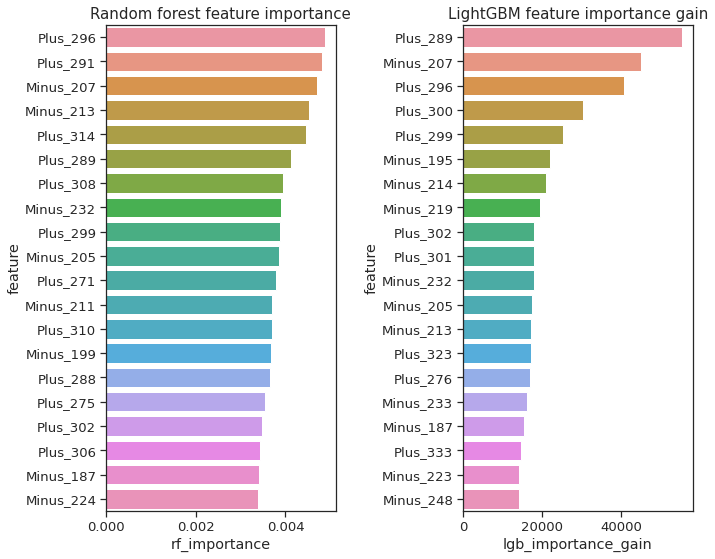

In [53]:
# Feature importance
imp_df = pd.DataFrame()
imp_df["feature"] = list(X_TRAIN.columns)
imp_df["rf_importance"] = rf_model.feature_importances_
imp_df["lgb_importance_gain"] = lgb_model.feature_importance(importance_type='gain')
imp_df["lgb_importance_split"] = lgb_model.feature_importance(importance_type='split')
display(imp_df)

plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, 0])
sns.barplot(x='rf_importance', y='feature', data=imp_df.sort_values('rf_importance', ascending=False).iloc[0:20], ax=ax)
plt.title("Random forest feature importance", fontsize=15)

ax = plt.subplot(gs[0, 1])
sns.barplot(x='lgb_importance_gain', y='feature', data=imp_df.sort_values('lgb_importance_gain', ascending=False).iloc[0:20], ax=ax)
plt.title("LightGBM feature importance gain", fontsize=15)

#ax = plt.subplot(gs[0, 2])
#sns.barplot(x='lgb_importance_split', y='feature', data=imp_df.sort_values('lgb_importance_split', ascending=False).iloc[0:20], ax=ax)
#ax.set_title('LightGBM feature importance split', fontsize=15)
plt.tight_layout()
plt.savefig(f"{DIRECTORY}feature_importance_{FILENAME}.png", dpi = 300)
plt.show()

In [54]:
# # LGBM Feature importance
# plt.rcParams['figure.figsize'] = (18.0, 4)
# fig, ax = plt.subplots(figsize=(12,8))
# lgb.plot_importance(lgb_model, max_num_features=20, height=0.8, ax=ax)
# ax.grid(False)
# plt.title("LightGBM feature importance ", fontsize=15)

## Performance evaluation

In [55]:
# Function to quickly add plot details
def plot_details(title = "", xlabel = "X-axis", ylabel = "Y-axis",
                 ax_equal = False, legend = True, leg_loc = None,
                 grid = True, save = False, filename = False):
    # Title and axis
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    if ax_equal == True:
        plt.axis('equal') 
    # Legend and grid
    if legend == True:
        legend = plt.legend(frameon = 1, loc = leg_loc, shadow = True)
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_edgecolor('black')
    if grid == True:
        plt.grid(zorder=0, color="lightgray")
    # Output
    if save == True:
        plt.savefig(filename + ".png", dpi = 300)
    plt.show()

#### Classification report

In [56]:
print("Random forest:\n", classification_report(rf_val_output["ytrue"], rf_val_output["ypred"]))     
print("LightGBM:\n",classification_report(lgb_val_output["ytrue"], lgb_val_output["ypred"]))
# print("SVC RBF:\n",classification_report(svc_val_output["ytrue"], svc_val_output["ypred"]))
# print("SVR RBF + LR:\n",classification_report(svr_val_output["ytrue"], svr_val_output["ypred"]))

Random forest:
               precision    recall  f1-score   support

         0.0       0.72      0.73      0.73     49422
         1.0       0.73      0.72      0.72     50069

    accuracy                           0.73     99491
   macro avg       0.73      0.73      0.73     99491
weighted avg       0.73      0.73      0.73     99491

LightGBM:
               precision    recall  f1-score   support

         0.0       0.69      0.86      0.77     49422
         1.0       0.82      0.61      0.70     50069

    accuracy                           0.74     99491
   macro avg       0.75      0.74      0.73     99491
weighted avg       0.75      0.74      0.73     99491



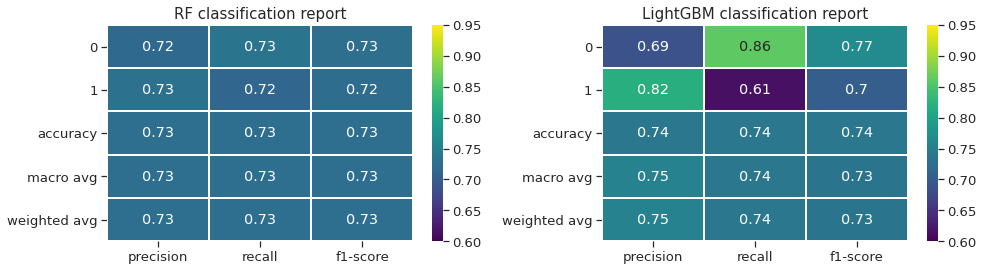

In [57]:
# Plot the classification report
plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, 0])
clf_report = classification_report(rf_val_output["ytrue"], rf_val_output["ypred"],
                                   labels=[0,1], output_dict=True)

sns.set(font_scale=1.2, style="ticks")                                
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, linewidths=1,
            cmap="viridis", ax=ax, vmin=0.6, vmax=0.95)

ax.set_title("RF classification report", fontsize=15)

ax = plt.subplot(gs[0, 1])
clf_report = classification_report(lgb_val_output["ytrue"], lgb_val_output["ypred"],
                                   labels=[0,1], output_dict=True)

sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, linewidths=1,
            cmap="viridis", vmin=0.6, vmax=0.95)
ax.set_title("LightGBM classification report", fontsize=15)

plt.tight_layout()
plt.savefig(f"{DIRECTORY}classification_report_{FILENAME}.png", dpi = 300)
plt.show()

#### Plot some metrics

In [58]:
def evaluate(ml_output):
  acc = get_accuracy(ml_output["ypred"], ml_output["ytrue"])
  f1 = f1_score(ml_output["ytrue"], ml_output["ypred"])
  mcc = matthews_corrcoef(ml_output["ytrue"], ml_output["ypred"])
  return acc, f1, mcc

# RF
rf_train_acc, rf_train_f1, rf_train_mcc = evaluate(rf_train_output)
rf_val_acc, rf_val_f1, rf_val_mcc = evaluate(rf_val_output)
# LGBM
lgb_train_acc, lgb_train_f1, lgb_train_mcc = evaluate(lgb_train_output)
lgb_val_acc, lgb_val_f1, lgb_val_mcc = evaluate(lgb_val_output)
# # SVC
# svc_train_acc, svc_train_rmse, svc_train_f1 = evaluate(svc_train_output)
# svc_val_acc, svc_val_rmse, svc_val_f1 = evaluate(svc_val_output)
# # SVR + LR
# svr_train_acc, svr_train_rmse, svr_train_f1 = evaluate(svr_train_output)
# svr_val_acc, svr_val_rmse, svr_val_f1 = evaluate(svr_val_output)

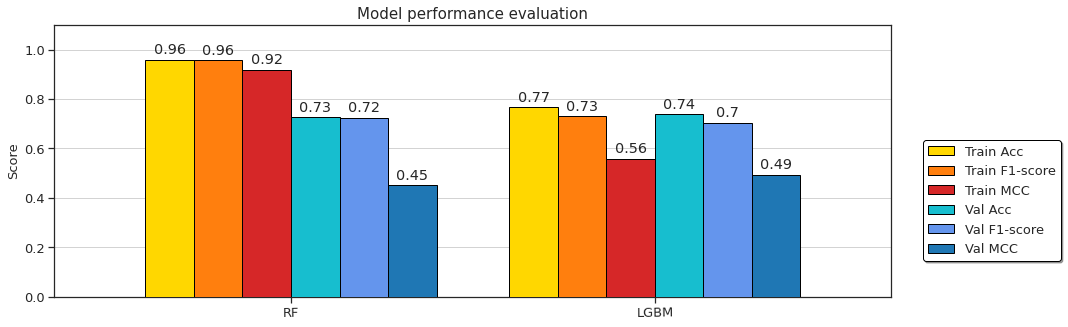

In [59]:
# Group by metrics
train_acc = rf_train_acc, lgb_train_acc
train_f1 = rf_train_f1, lgb_train_f1
train_mcc = rf_train_mcc, lgb_train_mcc
val_acc = rf_val_acc, lgb_val_acc
val_f1 = rf_val_f1, lgb_val_f1
val_mcc = rf_val_mcc, lgb_val_mcc

# Plot
metric_df = pd.DataFrame({"Train Acc": train_acc, "Train F1-score": train_f1, "Train MCC": train_mcc,
                          "Val Acc": val_acc, "Val F1-score": val_f1, "Val MCC": val_mcc, }, 
                          index = ["RF", "LGBM"])

ax = metric_df.plot(y=["Train Acc", "Train F1-score", "Train MCC", "Val Acc", "Val F1-score", "Val MCC"], 
                    ylim=(0,1.1), figsize=(15,5), fontsize=13,
                    kind="bar", zorder=3, ec ="black",
                    rot=1, width=0.8, color = ["gold", "tab:orange", "tab:red",
                                               "tab:cyan", "cornflowerblue", "tab:blue"])

# Add details
plt.title("Model performance evaluation", fontsize = 15)
plt.ylabel("Score", fontsize = 13)
plt.grid(axis="y", zorder=0, color="lightgray")  
legend = plt.legend(frameon = 1, shadow = True, bbox_to_anchor=(1.03, 0.6), fontsize=13)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
# Annotate scores on top of the bars
for p in ax.patches:
  height = p.get_height()
  ha = {'center': 'center', 'right': 'left', 'left': 'right'}
  xpos='center'
  offset = {'center': 0, 'right': 1, 'left': -1}
  ax.annotate(f"{height:.2}",
              xy=(p.get_x() + p.get_width() / 2, height),
              xytext=(offset[xpos]*3, 3),  
              textcoords="offset points",  
              ha=ha[xpos], va='bottom')
plt.savefig(f"{DIRECTORY}models_performance_{FILENAME}.png", 
            dpi = 300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

#### ROC

In [60]:
# # Compute AUC, FPR and TPR

# def get_auc_fpr_tpr(ml_output):
#   auc = roc_auc_score(ml_output["ytrue"], ml_output["ypred"])
#   fpr, tpr, _ = roc_curve(ml_output["ytrue"], ml_output["yprob"])
#   return auc, fpr, tpr

# rf_auc, fpr_rf, tpr_rf = get_auc_fpr_tpr(rf_val_output)
# lgb_auc, fpr_lgb, tpr_lgb = get_auc_fpr_tpr(lgb_val_output)
# #svc_auc, fpr_svc, tpr_svc = get_auc_fpr_tpr(svc_val_output)
# #svr_auc, fpr_svr, tpr_svr = get_auc_fpr_tpr(svr_val_output)

# # Plot ROC
# fig, ax = plt.subplots(1, 1, figsize = (6, 4))
# ax.plot(fpr_rf, tpr_rf, label=f"RF (AUC = {rf_auc:.3})")
# ax.plot(fpr_lgb, tpr_lgb, label=f"LGBM (AUC = {lgb_auc:.3})")
# #ax.plot(fpr_svc, tpr_svc, label=f"SVC RBF (AUC = {svc_auc:.3})")
# #ax.plot(fpr_svr, tpr_svr, label=f"SVR RBF + LR (AUC = {svr_auc:.3})")
# ax.plot([0, 1], [0, 1],'r--')
# plot_details(title = "ROC on validation data (CV)",
#              xlabel = '1 - Specificity (FPR)', 
#              ylabel = 'Sensitivity (TPR)',
#              leg_loc = "lower right",
#              save = True,
#              filename = f"{DIRECTORY}roc_{FILENAME}")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


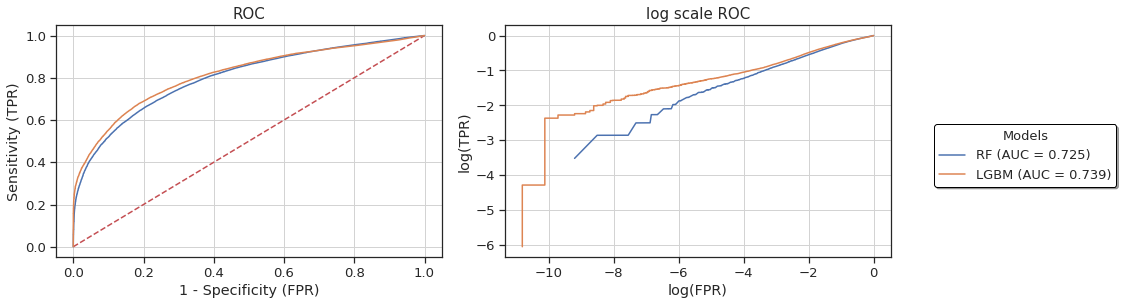

In [61]:
# Compute AUC, FPR and TPR

def get_auc_fpr_tpr(ml_output):
  auc = roc_auc_score(ml_output["ytrue"], ml_output["ypred"])
  fpr, tpr, _ = roc_curve(ml_output["ytrue"], ml_output["yprob"])
  return auc, fpr, tpr

rf_auc, fpr_rf, tpr_rf = get_auc_fpr_tpr(rf_val_output)
lgb_auc, fpr_lgb, tpr_lgb = get_auc_fpr_tpr(lgb_val_output)

# Plot ROC
fig, axes = plt.subplots(1, 2, figsize = (16, 4.5))
axes[0].plot(fpr_rf, tpr_rf, label=f"RF (AUC = {rf_auc:.3})", zorder=3)
axes[0].plot(fpr_lgb, tpr_lgb, label=f"LGBM (AUC = {lgb_auc:.3})", zorder=3)
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_title("ROC", fontsize=15)
axes[0].set_xlabel('1 - Specificity (FPR)')
axes[0].set_ylabel('Sensitivity (TPR)')
axes[0].grid(zorder=0, color="lightgray")

axes[1].plot(np.log(fpr_rf), np.log(tpr_rf), label=f"RF (AUC = {rf_auc:.3})", zorder=3)
axes[1].plot(np.log(fpr_lgb), np.log(tpr_lgb), label=f"LGBM (AUC = {lgb_auc:.3})", zorder=3)
axes[1].set_title("log scale ROC", fontsize=15)
axes[1].set_xlabel('log(FPR)')
axes[1].set_ylabel('log(TPR)')
axes[1].grid(zorder=0, color="lightgray")

# Details
legend = plt.legend(title="Models", fontsize=13, title_fontsize=13,
                    frameon = 1, shadow = True, bbox_to_anchor=(1.6, 0.6))
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
fig.tight_layout()
fig.subplots_adjust(top=0.89)
plt.savefig(f"{DIRECTORY}ROC_logROC_{FILENAME}.png", dpi = 300)
plt.show()

#### Precision recall curve

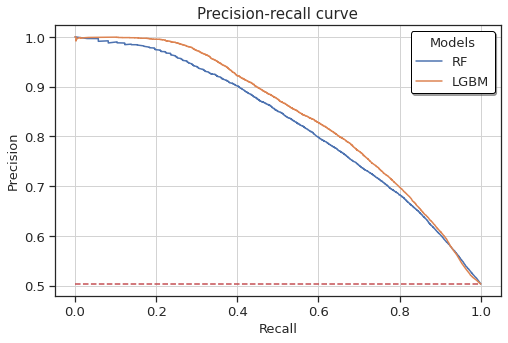

In [62]:
# Precision-recall curve
rf_precision, rf_recall, rf_thresholds = precision_recall_curve(rf_val_output["ytrue"], rf_val_output["yprob"])
lgb_precision, lgb_recall, lgb_thresholds = precision_recall_curve(lgb_val_output["ytrue"], lgb_val_output["yprob"])

# Plot the curves
plt.figure(figsize=(8, 5))
random_clf = len(rf_val_output["ytrue"][rf_val_output["ytrue"]==1]) / len(rf_val_output["ytrue"])
plt.plot([0, 1], [random_clf, random_clf], 'r--', zorder=3)
plt.plot(rf_recall, rf_precision, label='RF', zorder=3)
plt.plot(lgb_recall, lgb_precision, label='LGBM', zorder=3)

# Plot details
plt.grid(zorder=0, color="lightgray")
plt.xlabel("Recall", fontsize=13)
plt.ylabel("Precision", fontsize=13)
plt.title("Precision-recall curve", fontsize=15)
legend = plt.legend(title="Models", fontsize=13, title_fontsize=13,
           frameon = 1, shadow = True)
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_edgecolor("black")
plt.savefig(f"{DIRECTORY}precision-recall_curve_{FILENAME}.png", dpi = 300)
plt.show()

#### Confusion matrix

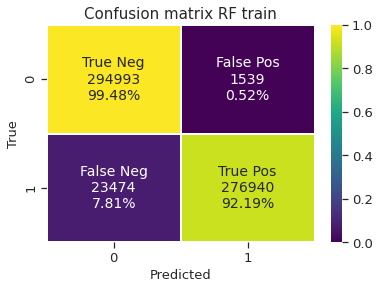

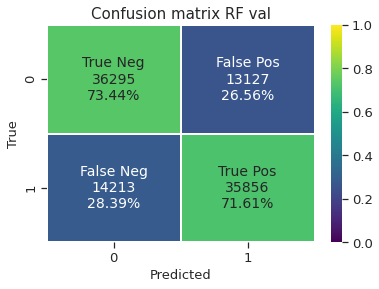

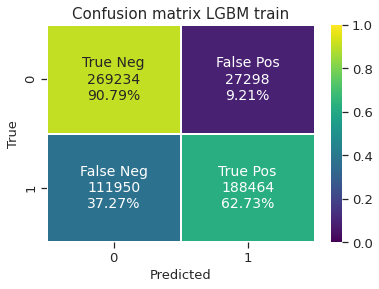

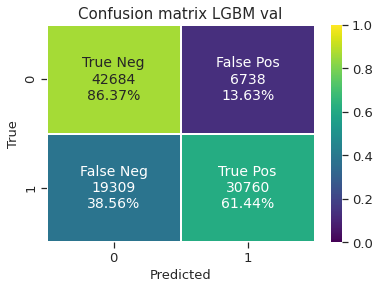

In [63]:
def plot_confusion_matrix(ml_output, title="", vmax=0.6,
                          save=False, filename="", cmap='viridis'):
  cf_matrix = confusion_matrix(ml_output["ytrue"], ml_output["ypred"])

  group_names = ["True Neg","False Pos","False Neg","True Pos"]
  group_counts = [f"{value}" for value in cf_matrix.flatten()]
  row_sums = cf_matrix.sum(axis=1)
  norm_matrix = cf_matrix / row_sums[:, np.newaxis]
  group_percentages = [f"{value*100:.2f}%" for value in norm_matrix.flatten()]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names, group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  plt.figure(figsize = (6,4))
  sns.set(font_scale=1.2, style="ticks")
  sns.heatmap(norm_matrix, annot=labels, annot_kws={"size": 14}, 
              fmt="", vmin=0, vmax=1, cmap=cmap, linewidths=1)
  sns.set(font_scale=1.3, style="ticks")
  plt.ylabel("True", fontsize = 13)
  plt.xlabel("Predicted", fontsize = 13)
  plt.title(f"Confusion matrix {title}", fontsize = 15)
  filename = title.replace(" ", "_")
  if save:
    plt.savefig(f"{DIRECTORY}confusion_matrix_{filename}_{FILENAME}.png", 
                dpi = 300)
  plt.show()

plot_confusion_matrix(rf_train_output, title="RF train", save=True)
plot_confusion_matrix(rf_val_output, title="RF val", save=True)

plot_confusion_matrix(lgb_train_output, title="LGBM train", save=True)
plot_confusion_matrix(lgb_val_output, title="LGBM val", save=True)


